# 计量经济系与机器学习

机器学习方法虽然善于预测，然而常用的方法多存在收缩偏误等问题，也很难做推断，这与计量经济学强调解释和因果是完全不同的两种工具方法。

然而，随着计量经济学的发展，模型函数形式设定问题以及处理效应异质性等问题也越来越多的被关注，而这些问题都可以借助机器学习的方法解决。

目前，在传统计量经济学中如何更好的结合机器学习方法仍然是一个活跃的领域，已经有很多方法聚焦于此。我们在这里简单介绍两类机器学习与计量经济学相结合的方法：因果森林和双重机器学习。

## 基于树的方法

基于决策树、随机森林的方法可以用于分类问题或者回归问题。根据因果推断的基础知识，在无混淆分配： $$W_{i}\amalg\left(Y_{i}\left(1\right),Y_{i}\left(0\right)\right)|X_{i}$$ 的假设下，对于平均处理效应（ATE）的一个简单的估计量为：$$\tau_{ATE}=\mathbb{E}\left[\frac{W_{i}Y_{i}}{P\left(X_{i}\right)}-\frac{\left(1-W_{i}\right)Y_{i}}{1-P\left(X_{i}\right)}\right]$$ 

然而处理效应经常是异质性的，我们或许更关心**异质性处理效应**（heterogeneous treatment effects），比如**条件平均处理效应**（conditonal average treatmen effects, CATE）：$$\tau\left(x\right)=CATE\left(x\right)=\mathbb{E}\left(Y_{i}\left(1\right)-Y_{i}\left(0\right)|x\right)$$ 此时，在无混淆分配的条件下，可以使用 $$\tau\left(x\right)=\mathbb{E}\left[\frac{W_{i}Y_{i}}{P\left(X_{i}\right)}-\frac{\left(1-W_{i}\right)Y_{i}}{1-P\left(X_{i}\right)}|X_i=x\right]$$ 进行识别。

至此，一个简单的方法即可以使用机器学习的方法对$P\left(X_{i}\right)$进行估计。

或者，为了获得更好的无偏性质和渐进分布性质，更好的方法是使用因果树（casal trees，Athey和Imbens，2016）和因果森林（causal forest，Wager and Athey，2018），其中后者是广义随机森林（generalized random forest，Athey, Tibshirani and Wager，2019）的一个特例。

使用决策树作为工具进行因果推断，一个基本的思路是通过决策树的分类，在同一个叶子节点$l$中的样本由于具有相似的特征，可以认为是随机分组的（无混淆分配）。从而对于同一个叶子节点，计算：$$\hat{\tau}\left(x\right)=\frac{1}{\#\left\{ W_{i}=1,i\in l\right\} }\sum_{\left\{ i:W_{i}=1,i\in l\right\} }Y_{i}-\frac{1}{\#\left\{ W_{i}=0,i\in l\right\} }\sum_{\left\{ i:W_{i}=0,i\in l\right\} }Y_{i}$$

然而在构建树时，必须决定如何划分特征空间，这一步骤可能带来bias，比如如果我们决定一个节点是否需要被分为两个，简单思路是当：$\bar{Y}_{1}-\bar{Y}_{0}>c$时分成两个节点，但是以上为样本，从总体的层面看可能并非如此，从而带来偏误。

为了解决这一问题，Athey和Imbens（2016）提出了“诚实树”（honest tree），即用于构建树的样本和用于估计参数/测试的样本是不同的。如此，对于估计参数所用的样本，树的结构是给定的，所以可以给出无偏估计。

与此同时，他们提出使用均方误差（MSE）作为目标，其中：

* 对于回归问题，最小化测试集上的MSE
* 对于因果推断问题，最小化条件处理效应的MSE——等价于最大化\hat{\tau}\left(x_{i}\right)的方差

背后的直觉是，通常的决策树会导致过拟合，而预测的方差大；而以上提出的方法对树的深度和总体的方差进行了惩罚。

在构建因果树的前提下，重复构建$B$颗树，就得到了因果森林，使用该方法所估计出的处理效应不仅是一致的，而且是渐进正态的，从而非常便于进行统计推断。Wager和Athey（2018）提出了两种构建树的方法：

* **双样本树**（**double-sample trees**）
* **倾向树**（**propensity trees**）

其中：

* **倾向树**：基于$W$的预测

  * 将$W$作为目标，训练一颗可以预测$W$的树
  * 从样本中进行无放回抽样
  * 每个叶子节点中每组样本量不少于$k$
  * 使用Gini系数等即可

* **双样本树**：直接基于$Y$（或者$\tau$）的预测


  *  从样本中进行无放回抽样，并将抽样得到的样本平均分为两份：$\mathcal{I}$和 $\mathcal{J}$
  *  使用$\mathcal{J}$的所有数据和$\mathcal{I}$的$X,W$数据生成树（不使用$\mathcal{I}$的$Y$数据），通过最大化$\hat{\tau}\left(X_{i}\right),i\in\mathcal{J}$的方差构建树，每个叶子节点中每组样本量不少于$k$
  *  使用$\mathcal{I}$的$Y$数据进行估计

接下来我们使用Lalonde数据对国家工作支持计划（NSW）进行政策评估：

首先导入模块和数据：

In [1]:
import pandas as pd
from econml.grf import CausalForest
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

data = pd.read_csv('csv/nsw_Lalonde.csv')
data=data[data['data_id']=='Lalonde Sample']
data.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,re74
0,Lalonde Sample,1,37,11,1,0,1,1,0.0,9930.04590,NaN
1,Lalonde Sample,1,22,9,0,1,0,1,0.0,3595.89400,NaN
2,Lalonde Sample,1,30,12,1,0,0,0,0.0,24909.44900,NaN
3,Lalonde Sample,1,27,11,1,0,0,1,0.0,7506.14600,NaN
4,Lalonde Sample,1,33,8,1,0,0,1,0.0,289.78989,NaN


其中处理状态为treat变量，age-nodegree为特征变量，结果变量为re78。

我们可以手动先分离出这些变量：

In [2]:
X = data[['age', 'education', 'black', 'hispanic', 'married', 'nodegree']]
Y = data['re78']
W = data['treat']


接下来初始化因果森林的估计类：

In [3]:
est = CausalForest(criterion='het',
                   n_estimators=1000,
                   honest=True,
                   min_samples_leaf=8,
                   max_depth=None,
                   n_jobs=-1,
                   random_state=1234)


其中：
* criterion='het' 代表使用方差而不是mse作为准则
* min_samples_leaf 代表每个叶子结点最少的样本量
* n_estimator 为森林中树的个数
* random_state 用于保证每次运行结果一样
* honest=True 代表使用honest tree
* n_jobs=-1为并行运算，使用所有核

接下来可以训练模型：

In [4]:
est.fit(X,W,Y)

CausalForest(criterion='het', min_samples_leaf=8, n_estimators=1000,
             random_state=1234)

接下来可以进行估计：

In [5]:
point, lb, ub = est.predict(X, interval=True, alpha=0.05)


接下来可以查看处理效应的异质性了，比如我们可以先给出一个年龄范围，然后查看在该年龄范围内处理效应的异质性，比如在下面我们计算了每个年龄下，其他特征为每个年龄段均值的条件下的异质性处理效应：

In [6]:
X_test=X.groupby('age').mean()
X_test['age']=X_test.index
X_test=pd.DataFrame(X_test, columns=['age', 'education', 'black', 'hispanic', 'married', 'nodegree'])
X_test.head()

,age,education,black,hispanic,married,nodegree
age,,,,,,
17,17,9.423077,0.769231,0.153846,0.000000,1.000000
18,18,9.706667,0.746667,0.200000,0.053333,0.920000
19,19,10.047619,0.714286,0.190476,0.063492,0.952381
20,20,10.275862,0.793103,0.120690,0.051724,0.758621
21,21,10.775000,0.700000,0.125000,0.100000,0.650000


以下绘制了异质性处理效应的值和置信区间：

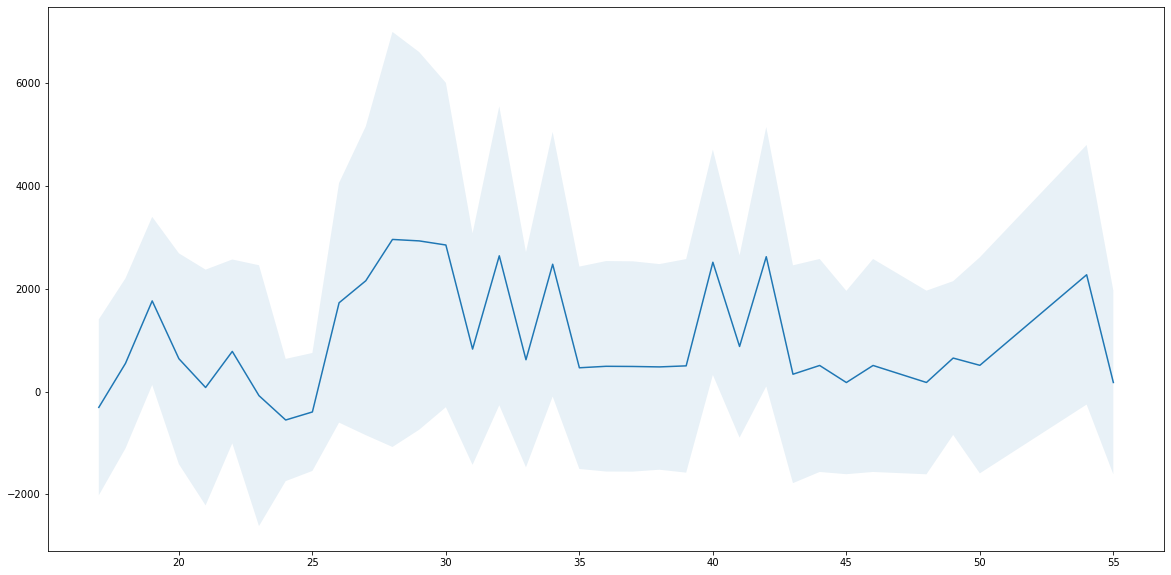

In [7]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.1)
X_test['tau'] = point
X_test['lb'] = lb
X_test['ub'] = ub
plt.figure(figsize=(20, 10))
plt.plot(X_test['age'], X_test['tau'])
plt.fill_between(X_test['age'],
                 X_test['lb'],
                 X_test['ub'],
                 alpha=.1)
plt.show()

以下代码则画出了第一棵树的图形：

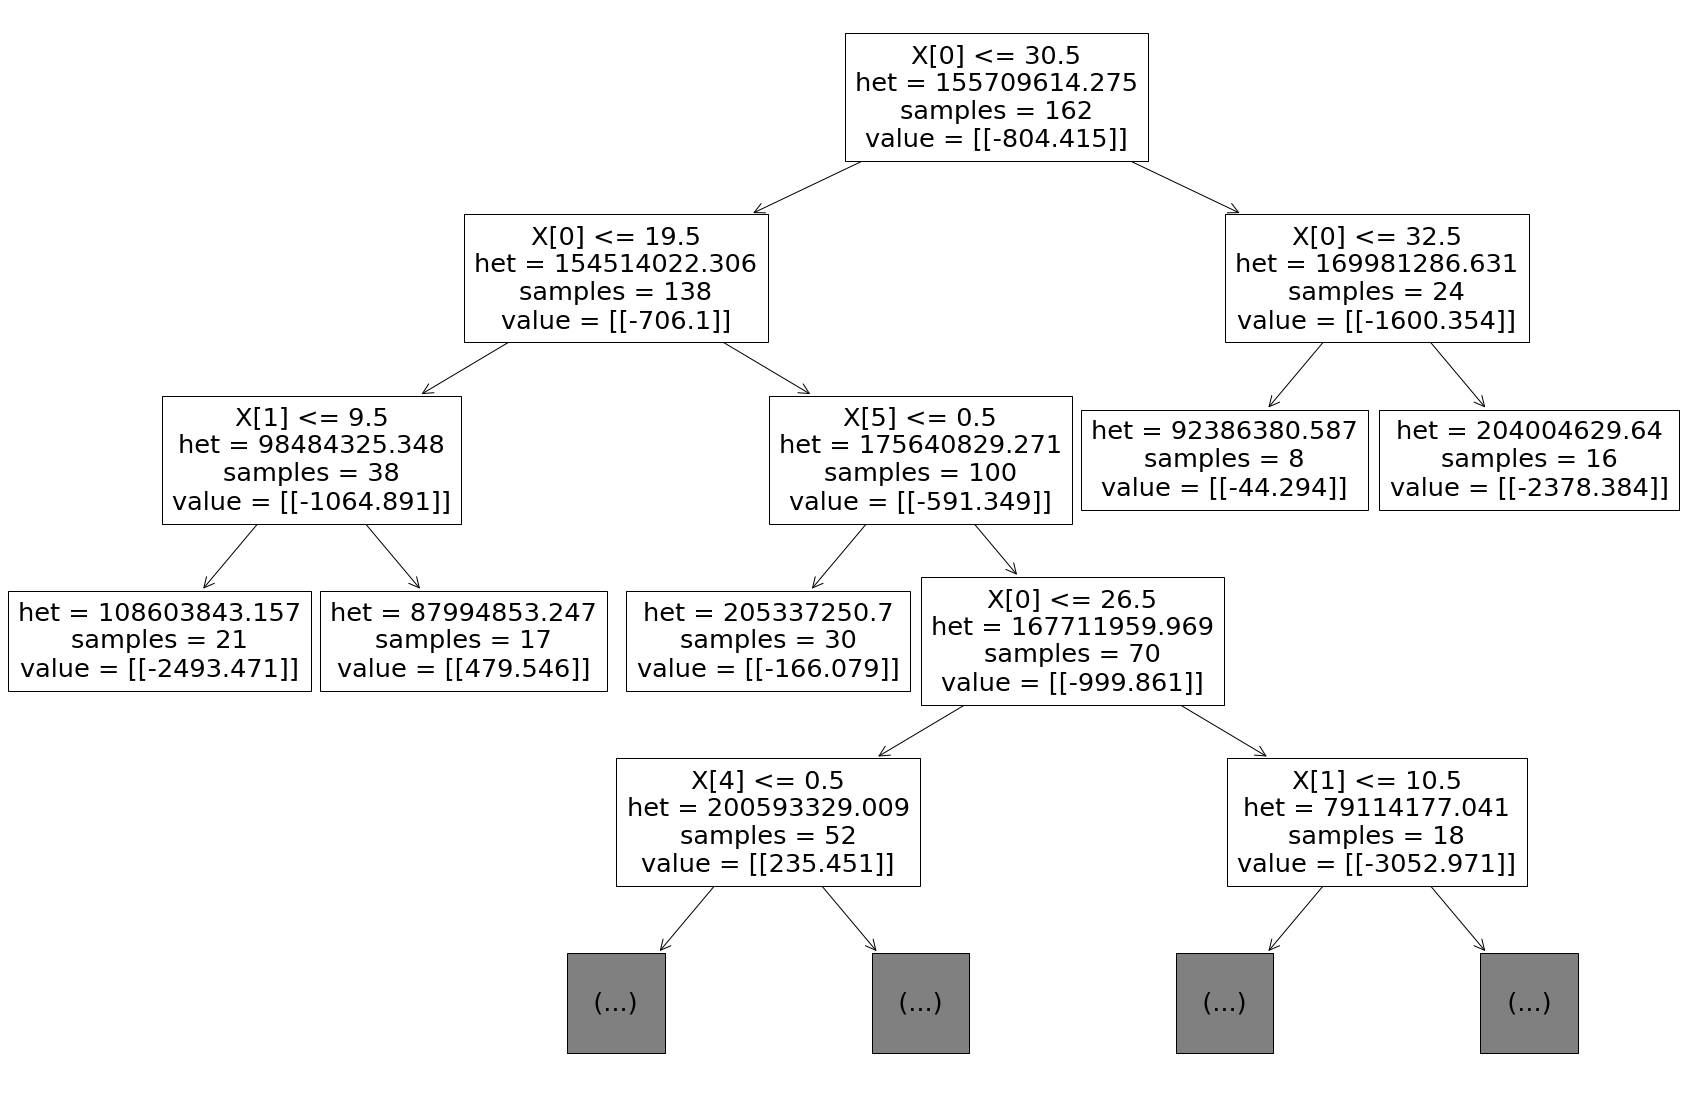

In [8]:
plt.figure(figsize=(30, 20))
plot_tree(est[0], impurity=True, max_depth=4)
plt.show()